In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/data.zip','r')
zip_train.extractall('/tmp')
zip_train.close()

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

warnings.filterwarnings("ignore")

Data Collection

In [ ]:
path = r"/tmp/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [ ]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [ ]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [ ]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [ ]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)


(5154, 128, 128, 1)


Data Visualization

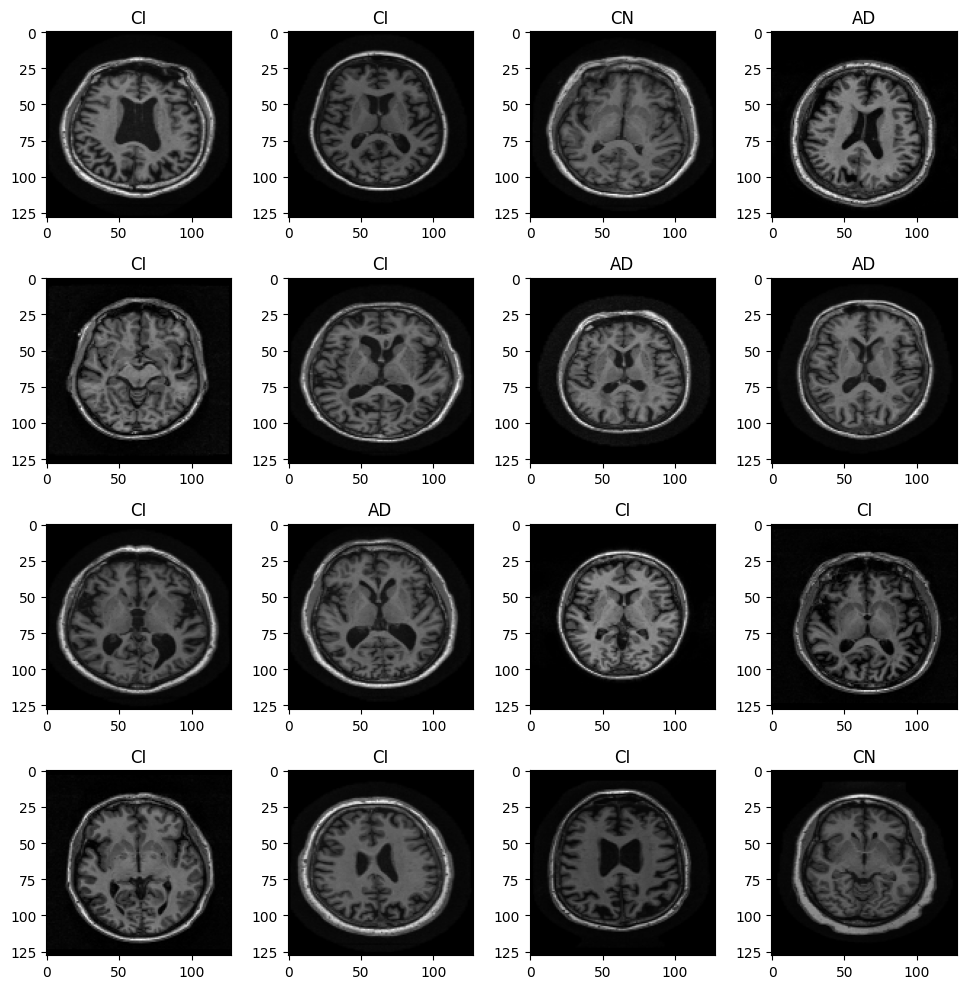

In [ ]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CI


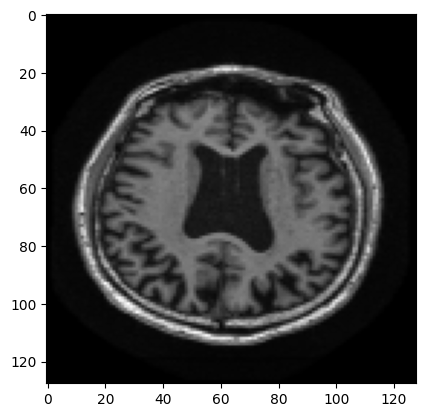

CN


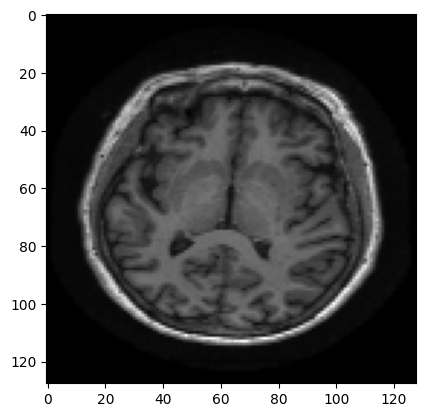

AD


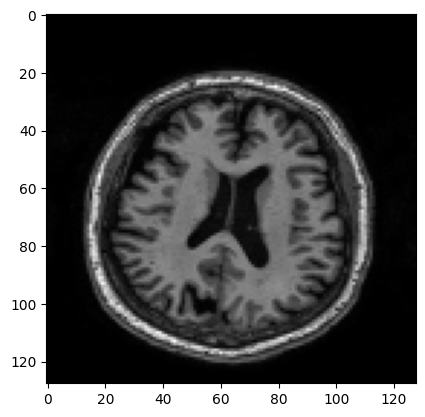

In [ ]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()


In [ ]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


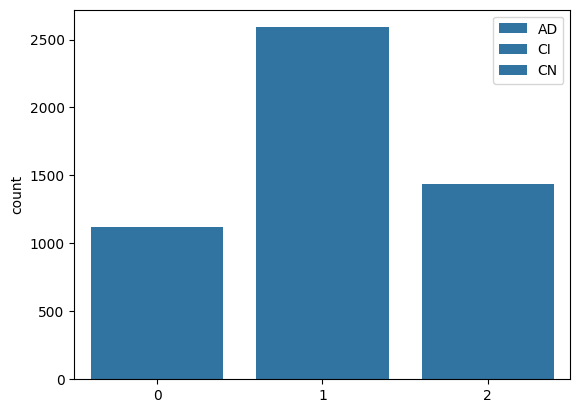

In [ ]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

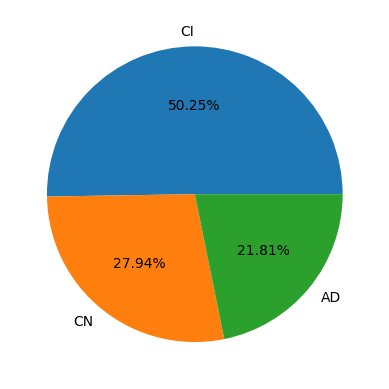

In [ ]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [ ]:
//SMOTE
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1

X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [ ]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [ ]:
print(pd.Series(y).value_counts())

1    3002
2    3002
0    3002
Name: count, dtype: int64


Data Preprocessing and Preparation

In [ ]:
# Min-Max Normalization

X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [ ]:

# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.2,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")


(6123, 128, 128, 1) (1081, 128, 128, 1) (1802, 128, 128, 1)
Total instances: 9006
Train instances: 6123           
Validation instances: 1081
Test instances: 1802


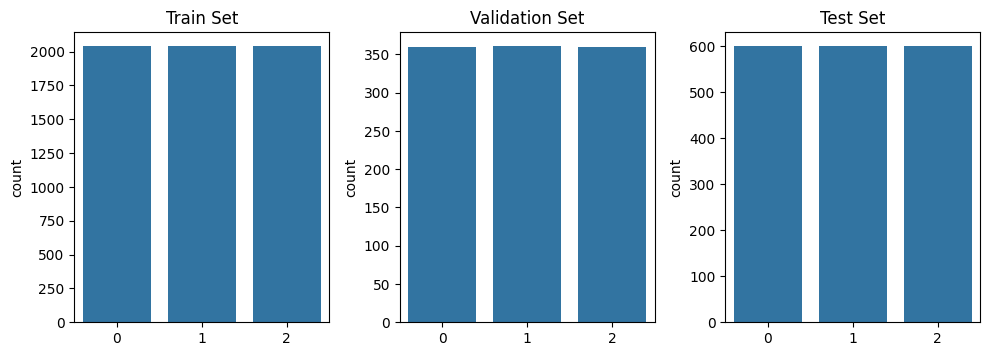

In [ ]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

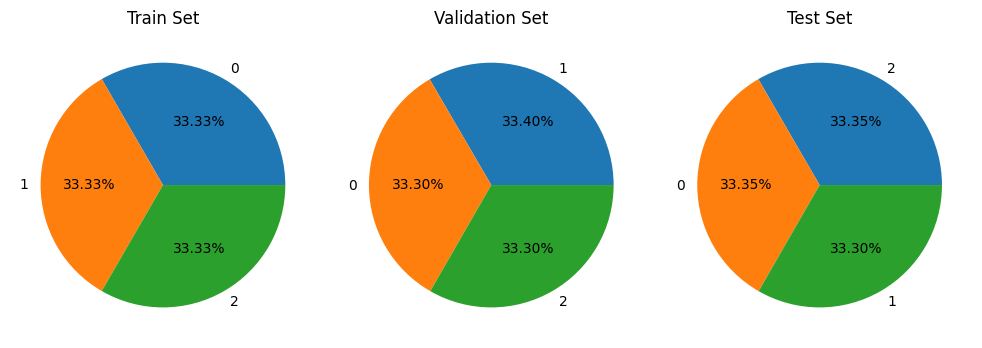

In [ ]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

Model Building and Training

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.9
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Regularization
dropout_rate = 0.3
kernel_regularizer = regularizers.l2(0.01)



class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

        self.query_layer = tf.keras.layers.Dense(units)
        self.key_layer = tf.keras.layers.Dense(units)
        self.value_layer = tf.keras.layers.Dense(units)

        self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs):
        query = self.query_layer(inputs)
        key = self.key_layer(inputs)
        value = self.value_layer(inputs)

        attention_weights = tf.matmul(query, key, transpose_b=True)
        attention_weights = self.softmax(attention_weights)

        output = tf.matmul(attention_weights, value)
        return output

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=200, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    SelfAttention(units=100),  # Adding Self-Attention layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dense(units=3, activation="softmax")
])


# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])#why optmizer



In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 200)       │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 42, 42, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 100)         │         180,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ self_attention (SelfAttention)       │ (None, 13, 13, 100)         │          30,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16900)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       1,690,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,907,703 (7.28 MB)

 Trainable params: 1,907,703 (7.28 MB)

 Non-trainable params: 0 (0.00 B)

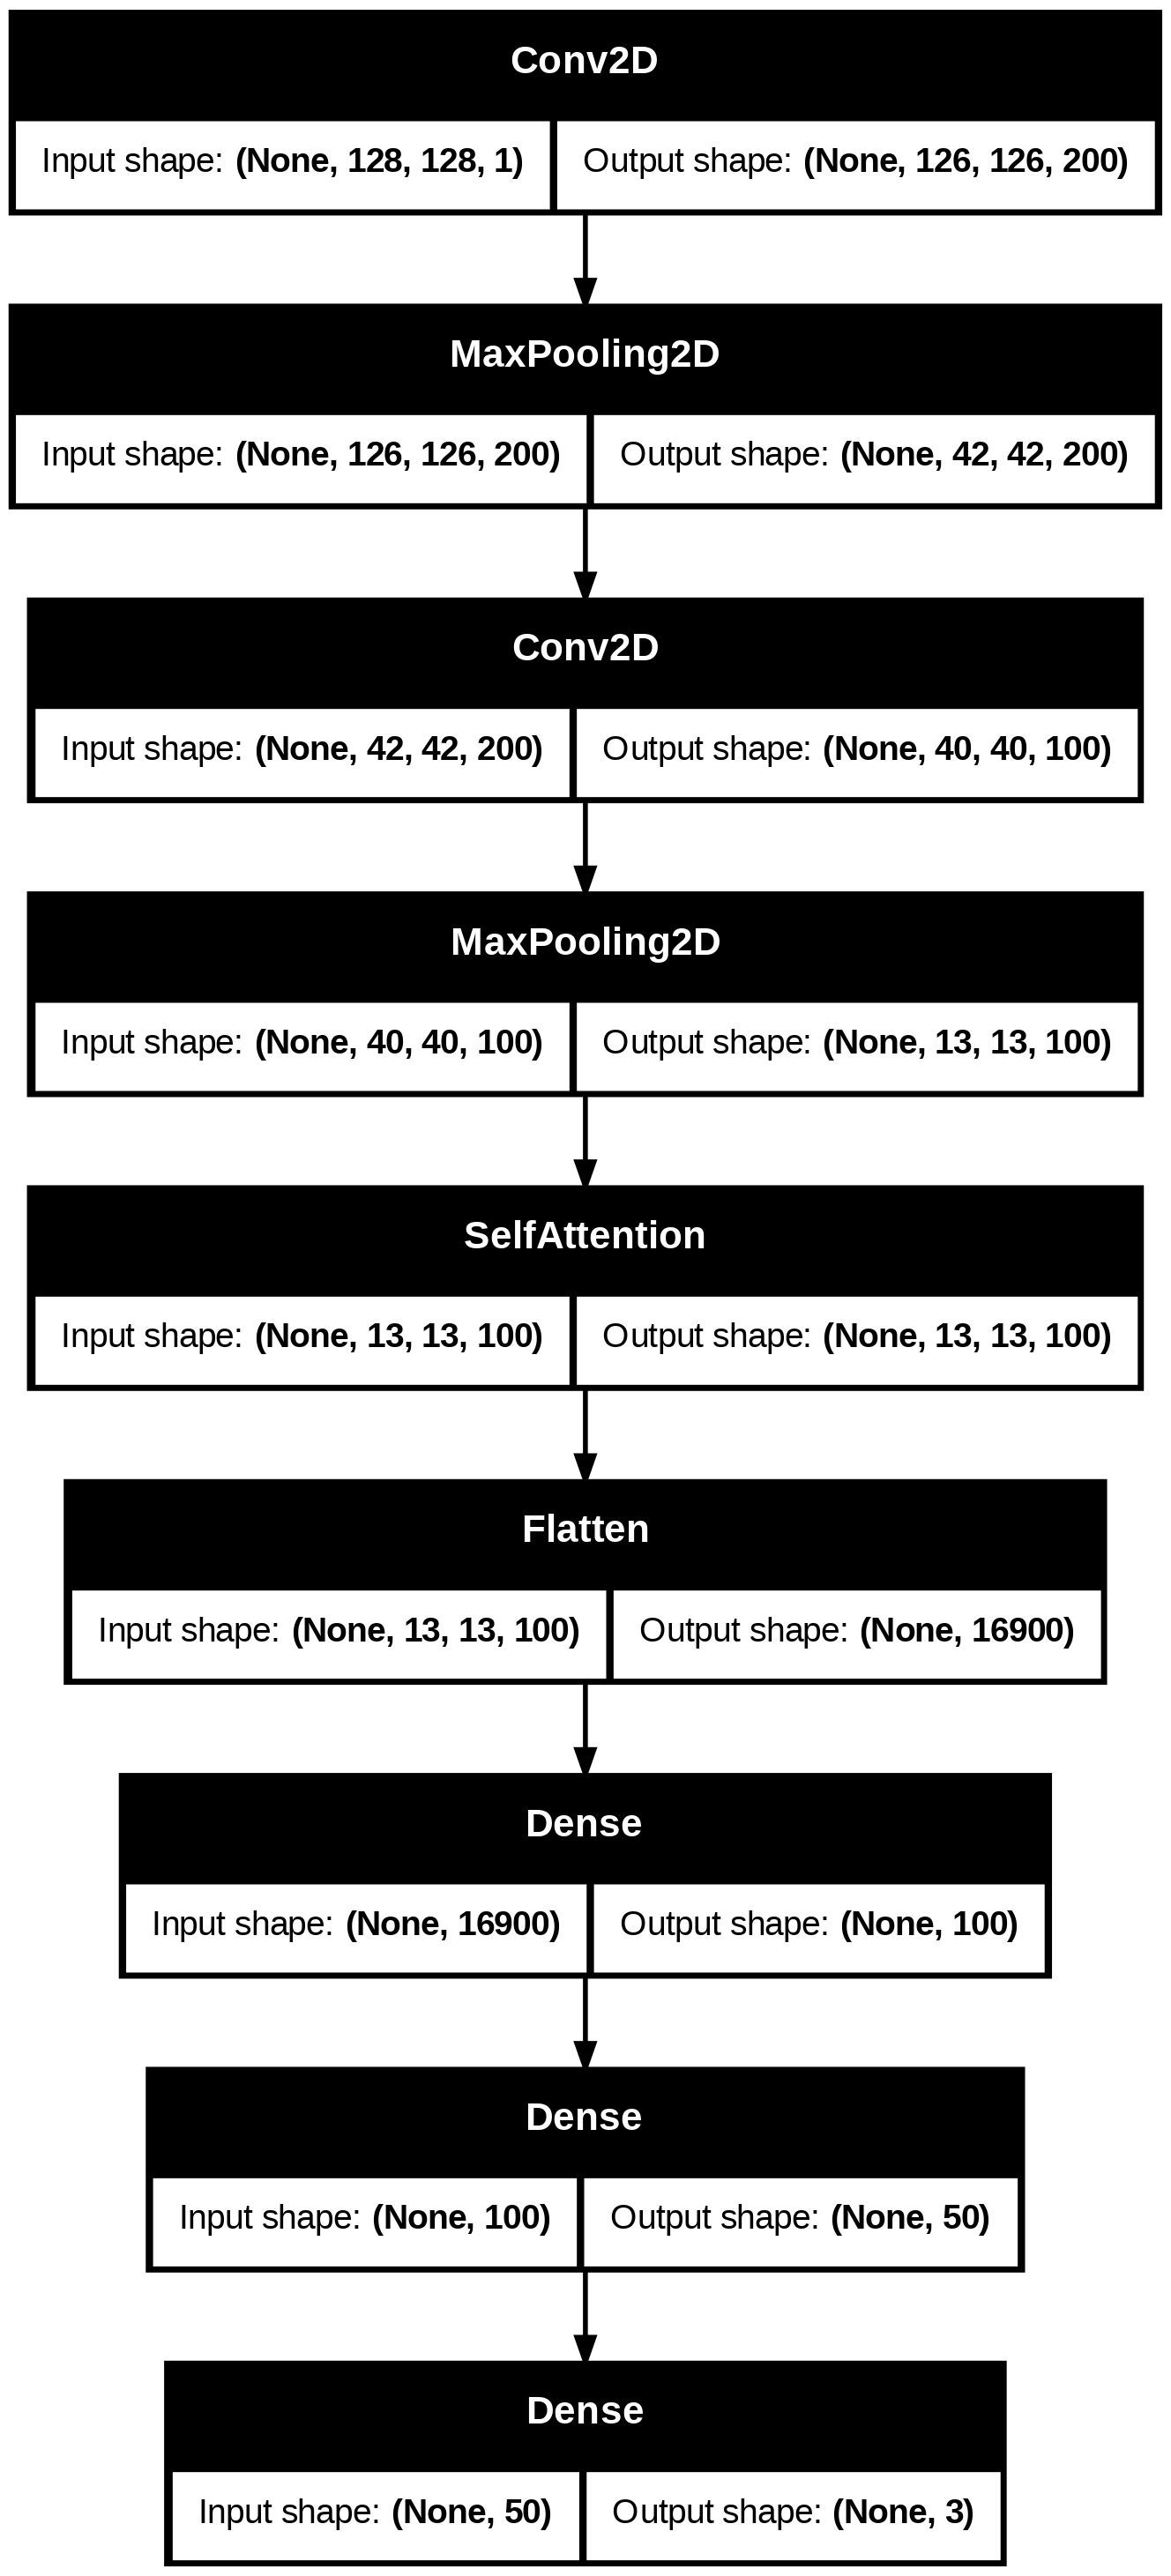

In [ ]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

In [ ]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only=True)
cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, callbacks=[cb1, cb2], validation_data=(X_val, y_val))


Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.3382 - loss: 1.1083 - val_accuracy: 0.4958 - val_loss: 1.0223
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.5344 - loss: 0.9689 - val_accuracy: 0.6318 - val_loss: 0.8202
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6499 - loss: 0.7962 - val_accuracy: 0.7493 - val_loss: 0.6241
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7858 - loss: 0.5344 - val_accuracy: 0.8936 - val_loss: 0.3329
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8938 - loss: 0.2892 - val_accuracy: 0.9223 - val_loss: 0.2225
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9456 - loss: 0.1542 - val_accuracy: 0.9445 - val_loss: 0.1630
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9649 - loss: 0.1051 - val_accuracy: 0.9241 - val_loss: 0.2324
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9751 - loss: 0.0

In [ ]:
result_df = pd.DataFrame(history.history)
result_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.372366,1.088406,0.495837,1.022328
1,0.551200,0.934687,0.631822,0.820195
2,0.683978,0.730469,0.749306,0.624069
3,0.819043,0.465984,0.893617,0.332908
4,0.901519,0.263037,0.922294,0.222458


In [ ]:
result_df.describe()

,accuracy,loss,val_accuracy,val_loss
count,22.000000,22.000000,22.000000,22.000000
mean,0.911778,0.195548,0.916534,0.221538
std,0.165430,0.317057,0.126945,0.260777
min,0.372366,0.002305,0.495837,0.057615
25%,0.948963,0.017853,0.929232,0.080673
50%,0.984648,0.051029,0.967160,0.114249
75%,0.993753,0.147004,0.981730,0.210452
max,0.999837,1.088406,0.986124,1.022328


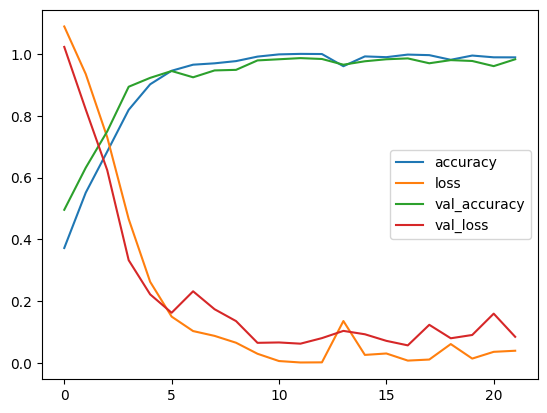

In [ ]:
# Learning curves

result_df.plot()
plt.show()

Model Validation

In [ ]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9835 - loss: 0.0449


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


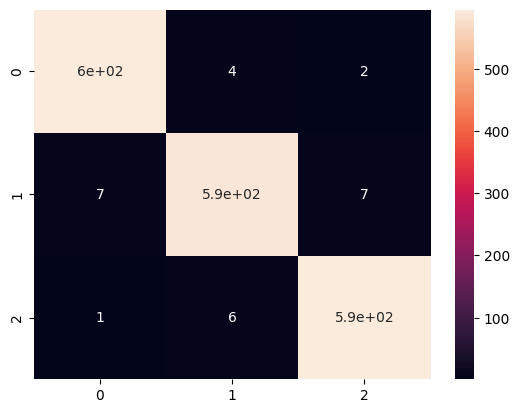

In [ ]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 595
True Negatives : 1193
False Positives : 8
False Negatives : 6

Precision : 0.9867330016583747
Recall (Sensitivity) : 0.9900166389351082
F1-Score : 0.9883720930232558


Class CI : 

True Positives : 586
True Negatives : 1192
False Positives : 10
False Negatives : 14

Precision : 0.9832214765100671
Recall (Sensitivity) : 0.9766666666666667
F1-Score : 0.9799331103678929


Class CN : 

True Positives : 594
True Negatives : 1192
False Positives : 9
False Negatives : 7

Precision : 0.9850746268656716
Recall (Sensitivity) : 0.9883527454242929
F1-Score : 0.9867109634551495


In [ ]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       601
           1       0.98      0.98      0.98       600
           2       0.99      0.99      0.99       601

    accuracy                           0.99      1802
   macro avg       0.99      0.99      0.99      1802
weighted avg       0.99      0.99      0.99      1802



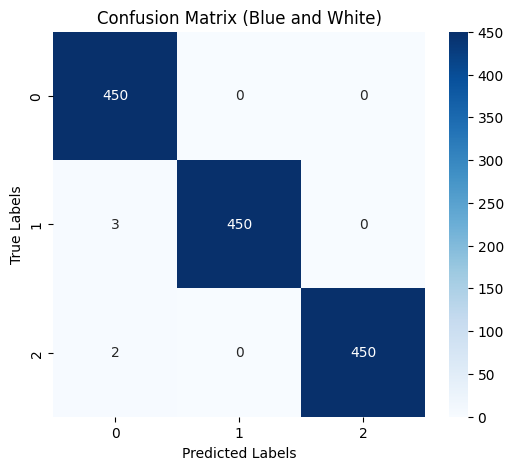

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example confusion matrix
confusion_matrix = np.array([[450, 0, 0],
                              [3, 450, 0],
                              [2, 0, 450]])

# Create the heatmap with blue and white color scheme
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=True)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Blue and White)")
plt.show()
